[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lior0110/main/blob/master/DJI_rnn1.ipynb)

In [0]:
import os 
if not os.path.exists('main'): os.system('git clone https://github.com/lior0110/main/')
os.chdir('main')

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# read the given data
data = pd.read_csv('DJI2.csv', index_col=0, parse_dates=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-03,12459.540039,12580.349609,12404.820313,12474.519531,12474.519531,327200000
2007-01-04,12473.160156,12510.410156,12403.860352,12480.690430,12480.690430,259060000
2007-01-05,12480.049805,12480.129883,12365.410156,12398.009766,12398.009766,235220000
2007-01-08,12392.009766,12445.919922,12337.370117,12423.490234,12423.490234,223500000
2007-01-09,12424.769531,12466.429688,12369.169922,12416.599609,12416.599609,225190000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3328 entries, 2007-01-03 to 2020-03-23
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3328 non-null   float64
 1   High       3328 non-null   float64
 2   Low        3328 non-null   float64
 3   Close      3328 non-null   float64
 4   Adj Close  3328 non-null   float64
 5   Volume     3328 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 182.0 KB


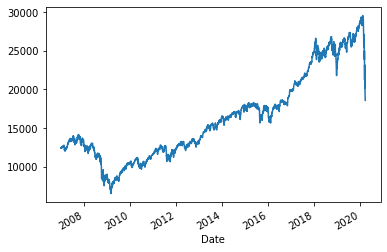

In [5]:
data['Adj Close'].plot()

In [0]:
# see if 'Adj Close' is the same as 'Close'
# if yes drop 'Adj Close'
test = data['Adj Close'] == data['Close']
if all(data['Adj Close'] == data['Close']):
    data = data.drop(columns='Adj Close')



In [7]:
data.head()


,Open,High,Low,Close,Volume
Date,,,,,
2007-01-03,12459.540039,12580.349609,12404.820313,12474.519531,327200000
2007-01-04,12473.160156,12510.410156,12403.860352,12480.690430,259060000
2007-01-05,12480.049805,12480.129883,12365.410156,12398.009766,235220000
2007-01-08,12392.009766,12445.919922,12337.370117,12423.490234,223500000
2007-01-09,12424.769531,12466.429688,12369.169922,12416.599609,225190000


In [8]:
data.tail()


,Open,High,Low,Close,Volume
Date,,,,,
2020-03-17,20487.050781,21379.349609,19882.259766,21237.380859,793060000
2020-03-18,20188.689453,20489.330078,18917.460938,19898.919922,871360000
2020-03-19,19830.009766,20442.630859,19177.130859,20087.189453,780300000
2020-03-20,20253.150391,20531.259766,19094.269531,19173.980469,872290000
2020-03-23,19028.359375,19121.009766,18213.650391,18591.929688,787970000


In [9]:
data.columns
data.shape

(3328, 5)

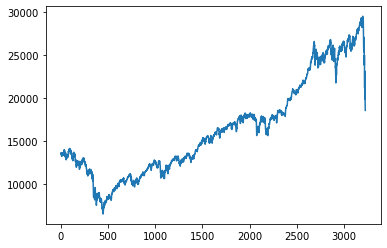

In [10]:
# make data and target arrays
target_style = 'Price' # / 'Price' / 'Change' / 'ChangeP' / 'UD'
window_len = 100 # window length to use for prediction
useVolume = True
y = np.zeros(data.shape[0]-window_len)
if useVolume:
  X = np.zeros((data.shape[0]-window_len,window_len,data.shape[1]))
else:
  X = np.zeros((data.shape[0]-window_len,window_len,data.shape[1]-1))


for i in range(data.shape[0]-window_len):
    if target_style == 'Change':
        # target of Change for next day
        y[i] = data['Close'][i+window_len] - data['Close'][i+window_len-1]
    elif target_style == 'ChangeP':
        # target of Change for next day in percentage
        y[i] = (data['Close'][i+window_len] - data['Close'][i+window_len-1]) / data['Close'][i+window_len-1]
    elif target_style == 'UD':
        # target of Up/Down for next day
        if (data['Close'][i+window_len] - data['Close'][i+window_len-1]) > 0:
          y[i] = 1
        elif (data['Close'][i+window_len] - data['Close'][i+window_len-1]) < 0:
          y[i] = -1
        else:
          y[i] = 0
        # y[i] = 1 if (data['Close'][i+window_len] - data['Close'][i+window_len-1]) > 0 else -1 
    else:
        # target of Price for next day
        y[i] = data['Close'][i+window_len]
        
    if useVolume:
      X[i,:,:] = data.iloc[i:i+window_len].values
    else:
      X[i,:,:] = data.iloc[i:i+window_len,:-1].values
    

plt.plot(y)
plt.show()

In [11]:
X[-1,-10:,:]
y[-1]

18591.929688

In [0]:
# train test split
y_train = y[:int(0.7*len(y))]
y_valid = y[int(0.7*len(y)):int(0.85*len(y))]
y_test = y[int(0.85*len(y)):]
X_train = X[:int(0.7*len(X)),:,:]
X_valid = X[int(0.7*len(X)):int(0.85*len(X)),:,:]
X_test = X[int(0.85*len(X)):,:,:]

In [13]:
# get the max and min in the train data
maxPrice = np.max(X_train[:,:,:-1])
print('max Price: ',maxPrice)
minPrice = np.min(X_train[:,:,:-1])
print('min Price: ',minPrice)

if useVolume:
  maxVolume = np.max(X_train[:,:,-1])
  print('max Volume: ',maxVolume)
  minVolume = np.min(X_train[:,:,-1])
  print('min Volume: ',minVolume)




max Price:  18351.359375
min Price:  6469.950195
max Volume:  674920000.0
min Volume:  8410000.0


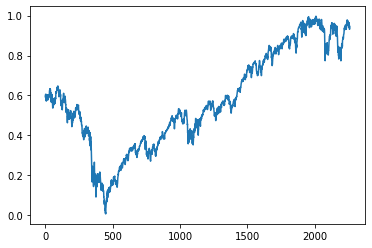

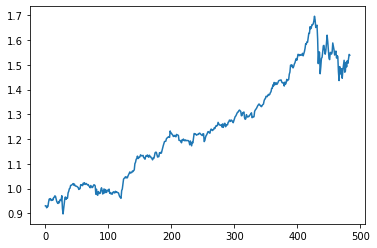

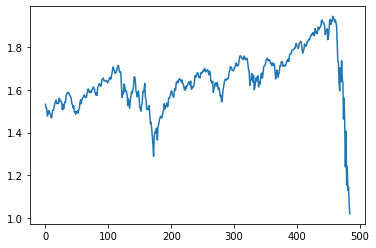

In [14]:
# data scaling
if useVolume:
  X_train[:,:,:-1] = (X_train[:,:,:-1] - minPrice) / (maxPrice - minPrice)
  X_train[:,:,-1] = (X_train[:,:,-1] - minVolume) / (maxVolume - minVolume)

  X_valid[:,:,:-1] = (X_valid[:,:,:-1] - minPrice) / (maxPrice - minPrice)
  X_valid[:,:,-1] = (X_valid[:,:,-1] - minVolume) / (maxVolume - minVolume)

  X_test[:,:,:-1] = (X_test[:,:,:-1] - minPrice) / (maxPrice - minPrice)
  X_test[:,:,-1] = (X_test[:,:,-1] - minVolume) / (maxVolume - minVolume)
else:
  X_train[:,:,:] = (X_train[:,:,:] - minPrice) / (maxPrice - minPrice)

  X_valid[:,:,:] = (X_valid[:,:,:] - minPrice) / (maxPrice - minPrice)

  X_test[:,:,:] = (X_test[:,:,:] - minPrice) / (maxPrice - minPrice)



# target scaling
if target_style == 'Price':
    y_train = (y_train - minPrice) / (maxPrice - minPrice)
    plt.plot(y_train)
    plt.show()
    y_valid = (y_valid - minPrice) / (maxPrice - minPrice)
    plt.plot(y_valid)
    plt.show()
    y_test = (y_test - minPrice) / (maxPrice - minPrice)
    plt.plot(y_test)
    plt.show()
elif target_style == 'Change':
    maxChange = np.max(np.abs(y_train))
    y_train = y_train / maxChange
    plt.plot(y_train)
    plt.show()
    y_valid = y_valid / maxChange
    plt.plot(y_valid)
    plt.show()
    y_test = y_test / maxChange
    plt.plot(y_test)
    plt.show()

In [0]:

# from keras.models import Sequential
# import keras.layers as layers
# from keras.layers import Input, Dense, Dropout, LSTM, CuDNNLSTM, GRU, CuDNNGRU, Bidirectional
# from keras.optimizers import SGD, RMSprop, Adam, Adagrad
# from keras.losses import mean_squared_error
# from keras.models import load_model
# from keras import backend as K
# from keras.callbacks import EarlyStopping


In [0]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [0]:

# The GRU architecture
regressorGRU = tf.keras.Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(layers.GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressorGRU.add(layers.Dropout(0.2))
# Second GRU layer
regressorGRU.add(layers.GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressorGRU.add(layers.Dropout(0.2))
# Third GRU layer
regressorGRU.add(layers.GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressorGRU.add(layers.Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(layers.GRU(units=50))
regressorGRU.add(layers.Dropout(0.2))
# The output layer
regressorGRU.add(layers.Dense(units=1))


In [0]:

# The LSTM architecture
regressorLSTM = tf.keras.Sequential()
# First LSTM layer with Dropout regularisation
regressorLSTM.add(layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressorLSTM.add(layers.Dropout(0.2))
# Second LSTM layer
regressorLSTM.add(layers.LSTM(units=50, return_sequences=True))
regressorLSTM.add(layers.Dropout(0.2))
# Third LSTM layer
regressorLSTM.add(layers.LSTM(units=50, return_sequences=True))
regressorLSTM.add(layers.Dropout(0.2))
# Fourth LSTM layer 
regressorLSTM.add(layers.LSTM(units=50))
regressorLSTM.add(layers.Dropout(0.2))
# The output layer
regressorLSTM.add(layers.Dense(units=1))


In [0]:
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    SS_reg = K.sum(K.square(y_pred - K.mean(y_true)))
#     return ( 1 - SS_res/(SS_tot + K.epsilon()) )
    return ( SS_res/(SS_tot + K.epsilon()) )
#     return ( SS_reg/(SS_tot + K.epsilon()) )

In [19]:
# regressor = regressorLSTM
regressor = regressorGRU
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
regressor.compile(optimizer='Adam', loss=r2_score, metrics=['mse',r2_score]) # optimizer='Adam'/'RMSProp'
print(regressor.summary())
hist = regressor.fit(X_train, y_train,epochs = 100, callbacks=[callback], validation_data=(X_valid, y_valid)) # , batch_size=32

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100, 50)           8550      
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 50)           15300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 50)           15300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)                1

In [20]:
hist.history.keys()

dict_keys(['loss', 'mse', 'r2_score', 'val_loss', 'val_mse', 'val_r2_score'])

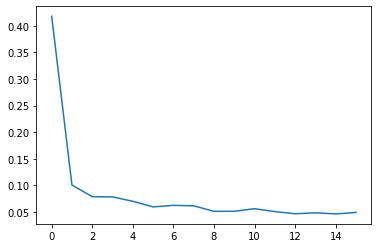

In [21]:
plt.plot(hist.history['loss'])
plt.show()

In [22]:
# predict for lest point
if useVolume:
  lest_data = data.iloc[-window_len:].values
  
  lest_data[:,:-1] = (lest_data[:,:-1] - minPrice) / (maxPrice - minPrice)
  lest_data[:,-1] = (lest_data[:,-1] - minVolume) / (maxVolume - minVolume)
else:
  lest_data = data.iloc[-window_len:,:-1].values
  lest_data = (lest_data - minPrice) / (maxPrice - minPrice)
lest_data = lest_data.reshape((1,window_len,X_train.shape[2]))

predicted_stock_price = regressor.predict(lest_data)
# target_style = 'Price' # / 'Price' / 'Change' / 'ChangeP' / 'UD'
if target_style == 'Price':
  predicted_stock_price = predicted_stock_price * (maxPrice - minPrice) + minPrice
  print("predicted stock price for next step is: ", predicted_stock_price)
elif target_style == 'Change':
  predicted_stock_price = predicted_stock_price * maxChange
  print("predicted stock price Change for next step is: ", predicted_stock_price)
elif target_style == 'ChangeP':
  print("predicted stock price Change percentage for next step is: ", predicted_stock_price)
elif target_style == 'UD':
  print("predicted stock price Up Down percentage for next step is: ", predicted_stock_price)


predicted stock price for next step is:  [[21651.14]]


In [0]:
predicted_stock_price = regressor.predict(X_test)
# if target_style == 'Price':
#     predicted_stock_price = (predicted_stock_price * (maxPrice - minPrice)) + minPrice
# predicted_stock_price

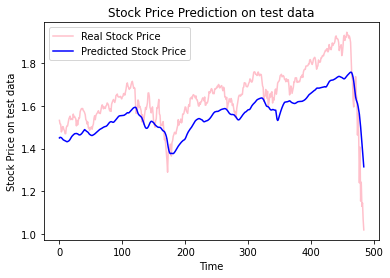

In [24]:
# Visualising the test results
plt.plot(y_test, color = 'pink', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction on test data')
plt.xlabel('Time')
plt.ylabel('Stock Price on test data')
plt.legend()
plt.show()

In [0]:
predicted_stock_price = regressor.predict(X_valid)
# if target_style == 'Price':
#     predicted_stock_price = (predicted_stock_price * (maxPrice - minPrice)) + minPrice
# predicted_stock_price

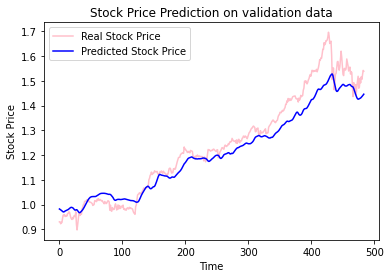

In [26]:
# Visualising the validation results
plt.plot(y_valid, color = 'pink', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction on validation data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [27]:
# r2_score(y_valid, predicted_stock_price)
SS_res = np.sum(np.square(y_valid - predicted_stock_price))
print('SS_res = ',SS_res)
SS_tot = np.sum(np.square(y_valid - np.mean(y_valid)))
print('SS_tot = ',SS_tot)
SS_reg = np.sum(np.square(predicted_stock_price - np.mean(y_valid)))
print('SS_reg = ',SS_reg)
r2 = 1 - SS_res/SS_tot
print('r2 = ',r2)
r2 = SS_reg/SS_tot
print('r2 = ',r2)
mse = np.mean(np.square(y_valid - predicted_stock_price))
print('mse = ',mse)

SS_res =  16466.8440850859
SS_tot =  20.45461493823702
SS_reg =  13.56779
r2 =  -804.0429761111491
r2 =  0.6633119260568446
mse =  0.07029422548445248


In [0]:
predicted_stock_price = regressor.predict(X_train)
# if target_style == 'Price':
#     predicted_stock_price = (predicted_stock_price * (maxPrice - minPrice)) + minPrice
# predicted_stock_price

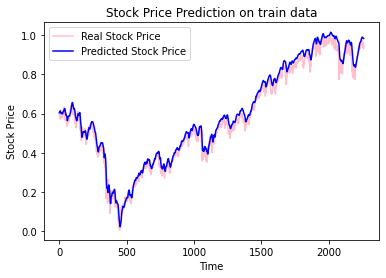

In [29]:
# Visualising the train results
plt.plot(y_train, color = 'pink', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction on train data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close('all')